(test-functions:rs-quadratic)=
# Quadratic RS Reliability Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uqtestfuns as uqtf

The Quadratic RS reliability problem is a variant of the classic RS problem
with one quadratic term {cite}`Waarts2000`.

The plots of the function are shown below. The left plot shows the surface
plot of the performance function, the center plot shows the contour
plot with a single contour line at function value of $0.0$ (the limit-state
surface), and the right plot shows the same plot with $10^6$ sample points
overlaid.

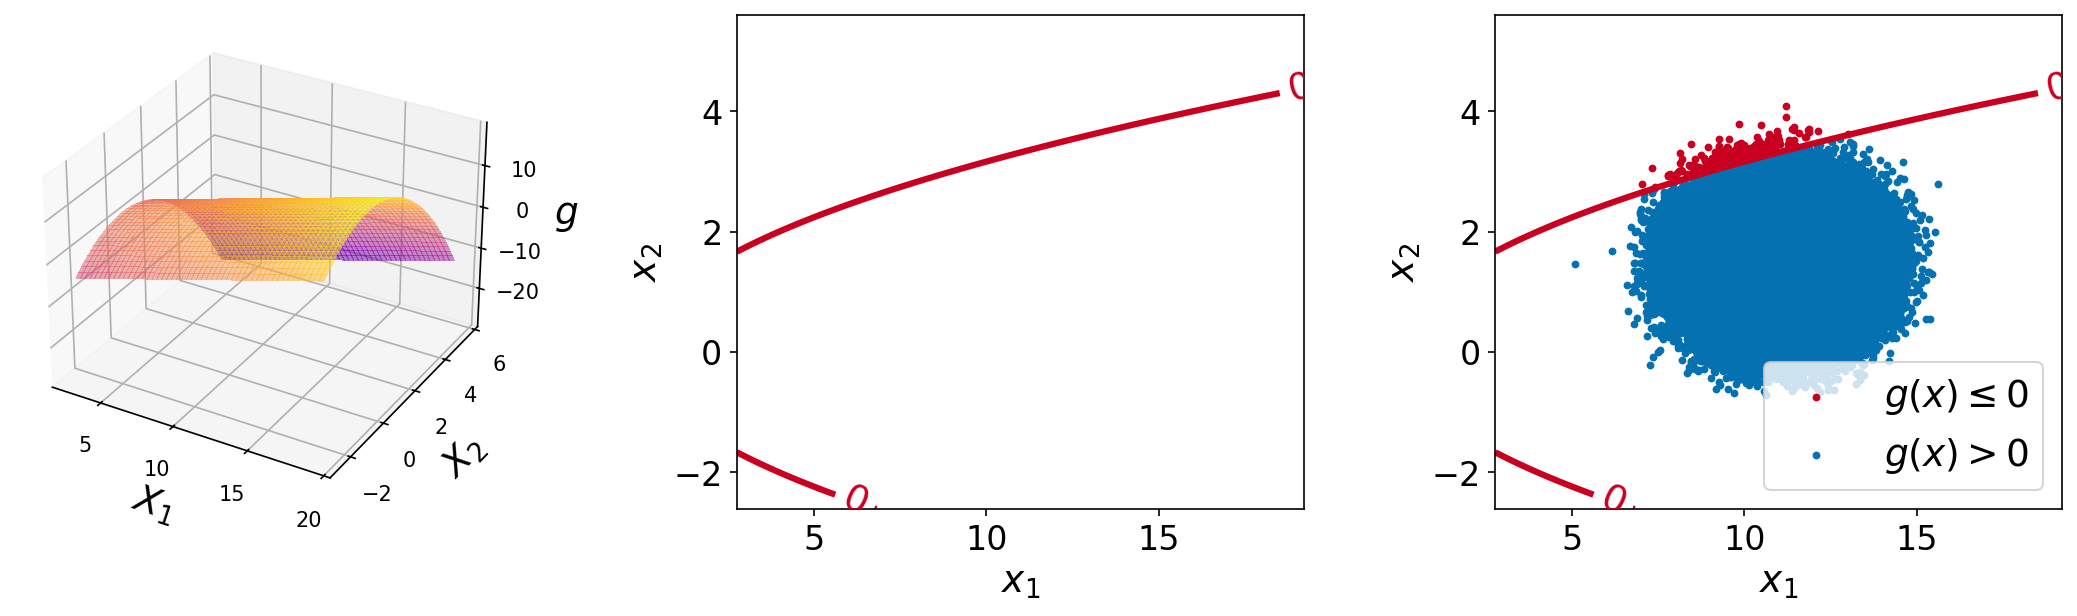

In [2]:
my_fun = uqtf.RSQuadratic()
my_fun.prob_input.reset_rng(237324)
xx = my_fun.prob_input.get_sample(1000000)
yy = my_fun(xx)
idx_neg = yy <= 0.0
idx_pos = yy > 0.0

lb_1 = my_fun.prob_input.marginals[0].lower
ub_1 = my_fun.prob_input.marginals[0].upper
lb_2 = my_fun.prob_input.marginals[1].lower
ub_2 = my_fun.prob_input.marginals[1].upper

# Create 2-dimensional grid
xx_1 = np.linspace(lb_1, ub_1, 1000)[:, np.newaxis]
xx_2 = np.linspace(lb_2, ub_2, 1000)[:, np.newaxis]
mesh_2d = np.meshgrid(xx_1, xx_2)
xx_2d = np.array(mesh_2d).T.reshape(-1, 2)
yy_2d = my_fun(xx_2d)

# --- Create the plot
fig = plt.figure(figsize=(15, 5))

# Surface
axs_0 = plt.subplot(131, projection='3d')
axs_0.plot_surface(
    mesh_2d[0],
    mesh_2d[1],
    yy_2d.reshape(1000,1000).T,
    linewidth=0,
    cmap="plasma",
    antialiased=False,
    alpha=0.5
)
axs_0.set_xlabel("$X_1$", fontsize=18)
axs_0.set_ylabel("$X_2$", fontsize=18)
axs_0.set_zlabel("$g$", fontsize=18)

# Contour plot
axs_1 = plt.subplot(132)
cf = axs_1.contour(
    mesh_2d[0],
    mesh_2d[1],
    yy_2d.reshape(1000, 1000).T,
    levels=0,
    colors=["#ca0020"],
    linewidths=[3.0],
)
axs_1.set_xlim([lb_1, ub_1])
axs_1.set_ylim([lb_2, ub_2])
axs_1.set_xlabel("$x_1$", fontsize=18)
axs_1.set_ylabel("$x_2$", fontsize=18)
axs_1.tick_params(labelsize=16)
axs_1.clabel(cf, inline=True, fontsize=18)

# Scatter plot
axs_2 = plt.subplot(133)
cf = axs_2.contour(
    mesh_2d[0],
    mesh_2d[1],
    yy_2d.reshape(1000, 1000).T,
    levels=0,
    colors=["#ca0020"],
    linewidths=[3.0],
)
axs_2.scatter(
    xx[idx_neg, 0],
    xx[idx_neg, 1],
    color="#ca0020",
    marker=".",
    s=30,
    label="$g(x) \leq 0$"
)
axs_2.scatter(
    xx[idx_pos, 0],
    xx[idx_pos, 1],
    color="#0571b0",
    marker=".",
    s=30,
    label="$g(x) > 0$"
)
axs_2.set_xlim([lb_1, ub_1])
axs_2.set_ylim([lb_2, ub_2])
axs_2.set_xlabel("$x_1$", fontsize=18)
axs_2.set_ylabel("$x_2$", fontsize=18)
axs_2.tick_params(labelsize=16)
axs_2.clabel(cf, inline=True, fontsize=18)
axs_2.legend(fontsize=18, loc="lower right");

fig.tight_layout(pad=4.0);
plt.gcf().set_dpi(150);

## Test function instance

To create a default instance of the test function:

In [3]:
my_testfun = uqtf.RSQuadratic()

Check if it has been correctly instantiated:

In [4]:
print(my_testfun)

Name              : RSQuadratic
Spatial dimension : 2
Description       : RS problem w/ one quadratic term from Waarts (2000)


## Description

The test function (i.e., the performance function) is analytically defined
as follows:

$$
g(\boldsymbol{x}) = x_1 - x_2^2,
$$

where $\boldsymbol{x} = \{ x_1, x_2 \}$ is the two-dimensional vector of
input variables probabilistically defined further below.

The failure state and the failure probability are defined as
$g(\boldsymbol{x}) \leq 0$
and $\mathbb{P}[g(\boldsymbol{X}) \leq 0]$, respectively.

## Probabilistic input

Based on {cite}`Waarts2000`, the probabilistic input model for
the test function consists of two independent standard normal random variables
(see the table below).

In [5]:
my_testfun.prob_input

ProbInput(spatial_dimension=2, marginals=(UnivDist(distribution='normal', parameters=array([11.,  1.]), name='X1', description='None'), UnivDist(distribution='normal', parameters=array([1.5, 0.5]), name='X2', description='None')), copulas=None, name='RSQuadratic-Waarts2000', description='Input model for the quadratic RS from Waarts (2000)')

## Reference results

This section provides several reference results of typical UQ analyses involving
the test function.

### Sample histogram

Shown below is the histogram of the output based on $10^6$ random points:

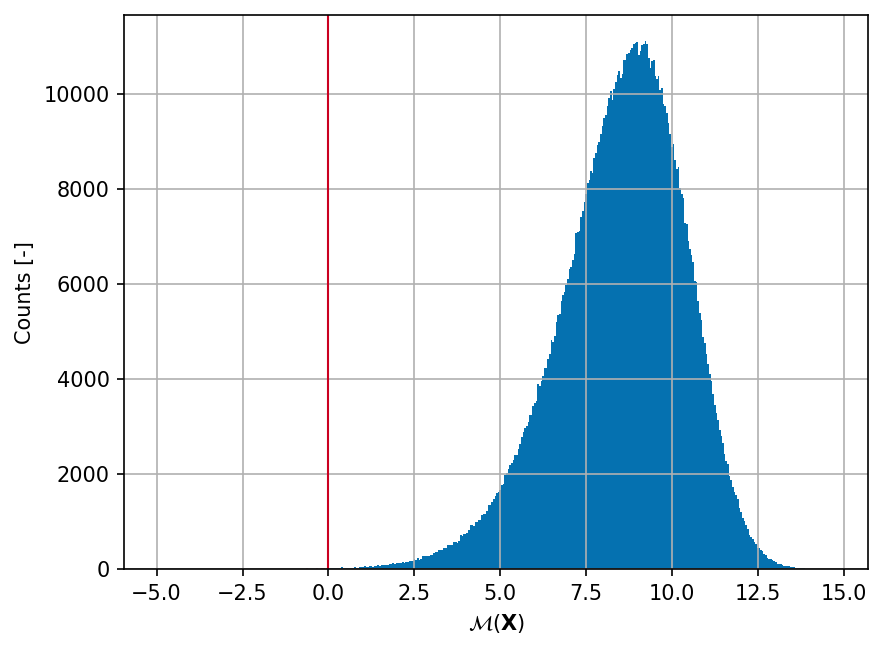

In [6]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    This is taken from:
    https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
    
    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

xx_test = my_testfun.prob_input.get_sample(1000000)
yy_test = my_testfun(xx_test)
yy_test = yy_test[~is_outlier(yy_test, thresh=10)]
idx_pos = yy_test > 0
idx_neg = yy_test <= 0

hist_pos = plt.hist(yy_test, bins="auto", color="#0571b0")
plt.hist(yy_test[idx_neg], bins=hist_pos[1], color="#ca0020")
plt.axvline(0, linewidth=1.0, color="#ca0020")

plt.grid()
plt.ylabel("Counts [-]")
plt.xlabel("$\mathcal{M}(\mathbf{X})$")
plt.gcf().set_dpi(150);

### Failure probability ($P_f$)

Some reference values for the failure probability $P_f$ from the literature
are summarized in the table below.

|    Method    |   $N$    |       $\hat{P}_f$       | $\mathrm{CoV}[\hat{P}_f]$ |       Source       | Remark                   |
|:------------:|:--------:|:-----------------------:|:-------------------------:|:------------------:|--------------------------|
|    Exact     | &#8212;  | $2.7009 \times 10^{-4}$ |          &#8212;          | {cite}`Waarts2000` | Annex E.3 Table: Results |
| {term}`FORM` |   $12$   | $2.6023 \times 10^{-4}$ |          &#8212;          | {cite}`Waarts2000` | Annex E.3 Table: Results |

## References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```

[^location]: see Annex E.3, p.151 in {cite}`Waarts2000`.